# Analyse planetary nebual
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : 16 September2021
- **kernel : anaconda3_auxtel**
- update : July 22th 2021
- update : September 16th 2021 



# Selection Flag

In [1]:
from astropy.io import fits
import sys, platform, os
#from astropy.visualization import simple_norm
#from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch
import astropy.visualization  as aspv
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from matplotlib.colors import LogNorm

In [2]:
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord

In [3]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,12)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

# Initialisation

## Configuration

In [4]:
m_to_mm=1000.
mm_to_m=1e-3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
mm_to_micr=1e3
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm
nm_to_micr=0.001

In [5]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [6]:
deg_to_rad=np.pi/180.

In [7]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

In [8]:
Tel_Focal_Length=20.6 # m : Focal length of the telescope
Tel_Diameter=1.2 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
plt_scale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

In [9]:
Det_xpic=10.0 # microns per pixel
Det_NbPix=4096 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

In [10]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Dispersion function

In [11]:
def Dispersion(wl,a,D):
    """
    - input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    all have the same unit
    """
    X=D/a*wl/np.sqrt(1-(wl/a)**2)
    return X

In [12]:
def Dispersion_Rate(wl,a,D):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in microns and lambdas in microns
    
    """
    dxdlambda=D/a*(np.sqrt(1-(wl/a)**2)+ (wl/a)**2)/(1-(wl/a)**2)
    return dxdlambda 

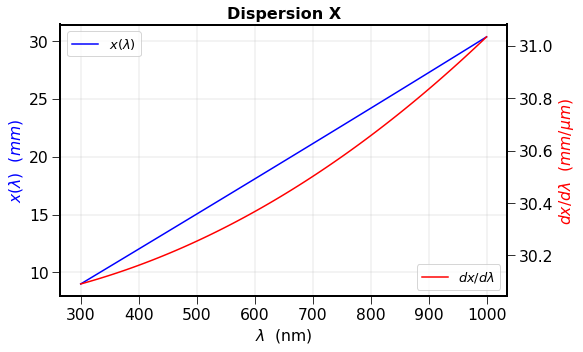

In [13]:
fig, ax1 = plt.subplots(figsize=(8,5))
WL=np.linspace(300.,1000.,100)
a=1/150.*mm_to_micr
D=200*mm_to_micr

Y1=Dispersion(WL*nm_to_micr,a,D)*micr_to_mm
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*nm_to_micr,a,D)*micr_to_mm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/\mu m$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()

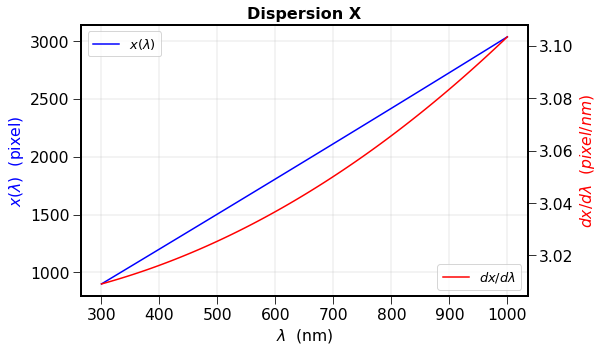

In [14]:
fig, ax1 = plt.subplots(figsize=(8,5))
WL=np.linspace(300.,1000.,100)
a=1/150.*mm_to_micr
D=200*mm_to_micr

Y1=Dispersion(WL*nm_to_micr,a,D)/Det_xpic   # pixel
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*nm_to_micr,a,D)/Det_xpic*1e-3   # pixel per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()

# Pixel to wavelength

In [15]:
WL=np.linspace(-1500.,1500.,300)

In [16]:
Npix=Dispersion(WL*nm_to_micr,a,D)/Det_xpic   # pixel

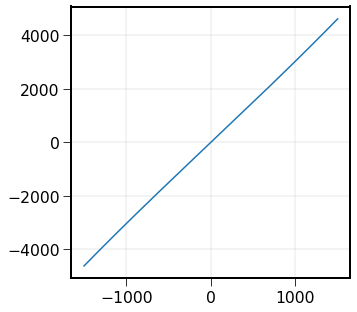

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(WL,Npix)
ax.grid()

In [18]:
from scipy import interpolate

In [19]:
pixel_to_wavelength=interpolate.interp1d(Npix,WL)

In [20]:
Npix.min()

-4618.422052117069

In [21]:
Npix.max()

4618.422052117069

# Target

In [22]:
target_name="PNG321.0+03.9"

In [23]:
target_coord=SkyCoord.from_name(target_name)
target_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (224.97283918, -54.3020902)>

In [24]:
tagname=".*(PNG).*"

# Work

In [25]:
# CCIN2P3
#intputdir_day_1="/sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-07/"   
intputdir="/sps/lsst/groups/auxtel/data/2021/holo/quickLookExp/2021-09-09/"   
# Local
intputdir="/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp/2021-09-09"
list_of_files=os.listdir(intputdir)    

In [26]:
print(list_of_files)

['holo4_003_empty_HD2811_20210909_000595_quickLookExp.fits', 'holo4_003_empty_PNG321.0+03.9_20210909_000170_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000589_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000571_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000568_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000590_quickLookExp.fits', 'holo4_003_empty_PNG321.0+03.9_20210909_000175_quickLookExp.fits', 'holo4_003_empty_PNG321.0+03.9_20210909_000169_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000574_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000594_quickLookExp.fits', 'holo4_003_empty_PNG321.0+03.9_20210909_000171_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000588_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000570_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000569_quickLookExp.fits', 'holo4_003_empty_HD2811_20210909_000591_quickLookExp.fits', 'holo4_003_empty_PNG321.0+03.9_20210909_000174_quickLookExp.fits', 'hol

In [27]:
bad_files = []
idx=0
for file in list_of_files:
    if re.search(".*(PNG).*",file):
        print(file)
    else:
        bad_files.append(idx)
        
    idx+=1
        

holo4_003_empty_PNG321.0+03.9_20210909_000170_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000175_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000169_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000171_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000174_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000168_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000176_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000166_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000167_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000165_quickLookExp.fits


In [28]:
#list_of_file=np.array(list_of_files)
list_of_files=np.delete(list_of_files,bad_files)

In [29]:
idx_file=0

In [30]:
fits_image_filename=list_of_files[idx_file]
full_fits_image_filename=os.path.join(intputdir,fits_image_filename)

In [31]:
fits_image_filename

'holo4_003_empty_PNG321.0+03.9_20210909_000170_quickLookExp.fits'

In [32]:
hdul = fits.open(full_fits_image_filename)

In [33]:
hdul.info()

Filename: /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp/2021-09-09/holo4_003_empty_PNG321.0+03.9_20210909_000170_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [34]:
image=hdul[0].data
header=hdul[0].header

In [35]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-09-09T23:56:26.087'                                             
DATE-OBS= '2021-09-09T23:56:30.224'                                             
DATE-BEG= '2021-09-09T23:56:30.224'                                             
DATE-END= '2021-09-09T23:57:00.456'                                             
MJD     =     59466.9975241522                                                  
MJD-OBS =     59466.99757203

In [36]:
image.shape

(4000, 4072)

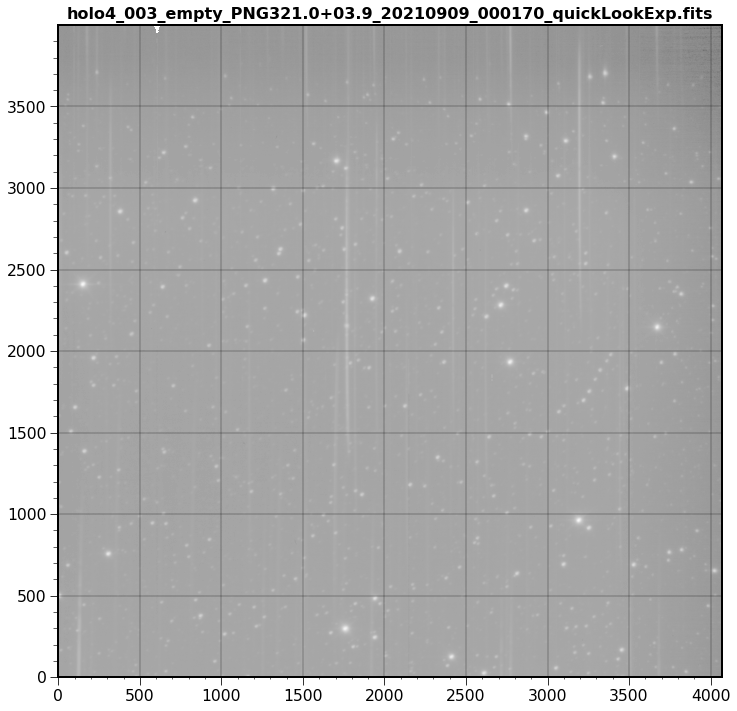

In [37]:
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(1,1,1)

ax.imshow(image,origin="lower",norm=LogNorm(),cmap="gray")

ax.minorticks_on()
ax.grid(color="k")
ax.set_title(fits_image_filename)
ax.grid(color="k")

# Spectrum

In [38]:
target_name="PNG321.0+03.9"

In [39]:
target_coord=SkyCoord.from_name(target_name)
target_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (224.97283918, -54.3020902)>

In [40]:
Xcenter=1760
Ycenter=300
dX=10

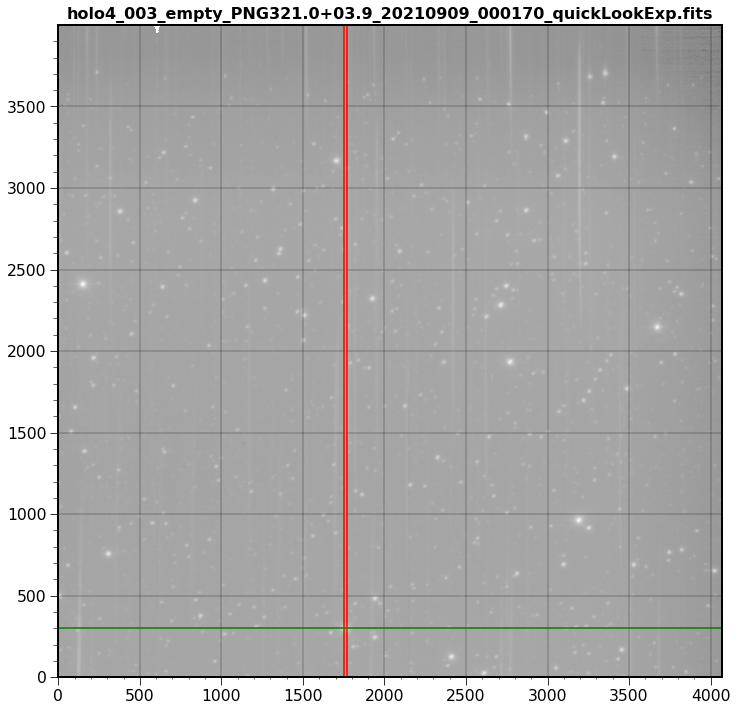

In [41]:
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(1,1,1)

ax.imshow(image,origin="lower",norm=LogNorm(),cmap="gray")

ax.minorticks_on()
ax.grid(color="k")
ax.set_title(fits_image_filename)
ax.axvline(x=Xcenter,color="y")
ax.axvline(x=Xcenter-dX,color="r")
ax.axvline(x=Xcenter+dX,color="r")

ax.axhline(y=Ycenter,color="g")

ax.grid(color="k")

In [42]:
spectrum=np.copy(image[:,Xcenter-dX:Xcenter+dX]).sum(axis=1)

In [43]:
spectrum_index=np.arange(spectrum.size)

In [44]:
spectrum_index-Ycenter

array([-300, -299, -298, ..., 3697, 3698, 3699])

In [45]:
wl= pixel_to_wavelength(spectrum_index-Ycenter)

Text(0.5, 0, '$\\lambda$ (nm)')

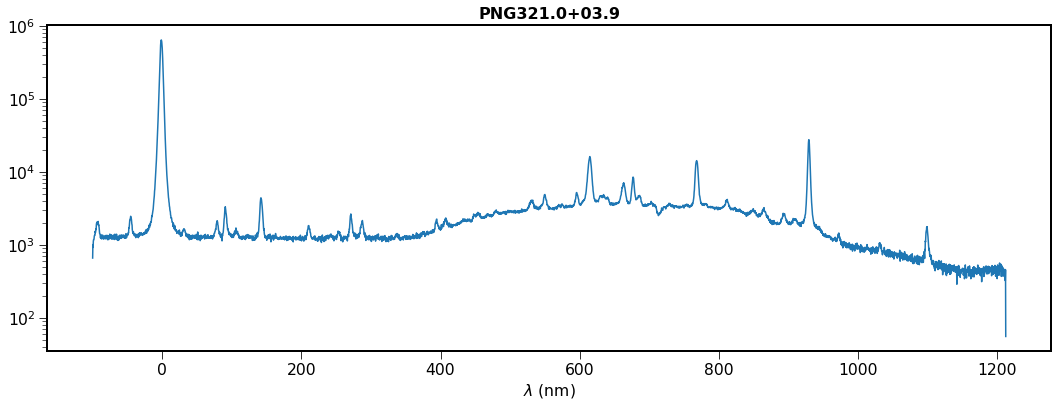

In [46]:
fig=plt.figure(figsize=(18,6))
ax=fig.add_subplot(1,1,1)

ax.semilogy(wl,spectrum)
ax.set_title(target_name)
ax.set_xlabel("$\lambda$ (nm)")

## All spectra

In [47]:
all_images=[]
all_id=[]
all_expo=[]

idx=0
for file in list_of_files:
    full_fits_image_filename=os.path.join(intputdir,file)
    hdu = fits.open(full_fits_image_filename)
    image=hdu[0].data
    header=hdu[0].header
    all_id.append(header['SEQNUM'])
    all_expo.append(header['EXPTIME'])
    all_images.append(image)
    idx+=1
    

In [48]:
header['SEQNUM']

165

In [49]:
NB=len(all_id)

In [50]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [51]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NB)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NB), alpha=1)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


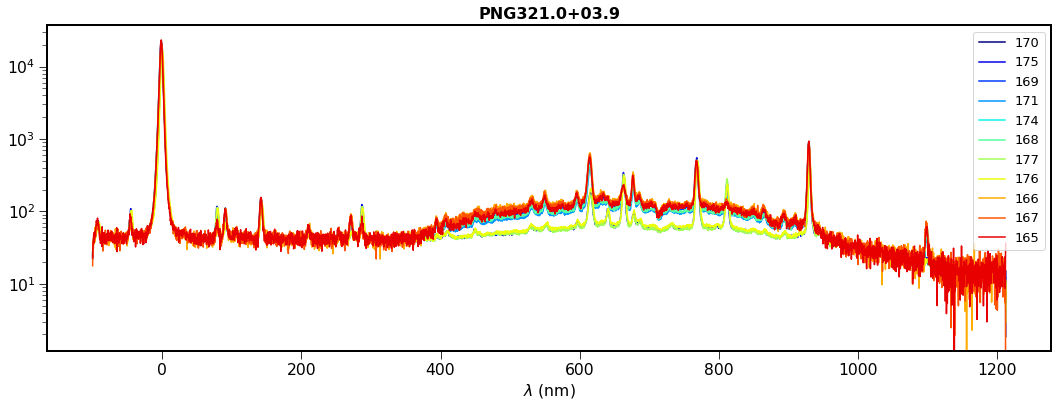

In [52]:
fig=plt.figure(figsize=(18,6))
ax=fig.add_subplot(1,1,1)

for idx in np.arange(NB):
    the_image=all_images[idx]
    spectrum=np.copy(the_image[:,Xcenter-dX:Xcenter+dX]).sum(axis=1)
    spectrum_index=np.arange(spectrum.size)
    wl= pixel_to_wavelength(spectrum_index-Ycenter)
    ax.semilogy(wl,spectrum/all_expo[idx],label=str(all_id[idx]),color=all_colors[idx])
    
    
ax.set_title(target_name)
ax.set_xlabel("$\lambda$ (nm)")
ax.legend()
    
    